# Data Science for E-Commerce
## Insights
Refer to the notebook ecommerce_explanatory.ipynb for the exploratory analysis, and to ecommerce_SARIMA.ipynb for the sales predictions.

There are 3 parts in this notebook, concerning the analysis of:
- Price of the items, quantity, revenue
- Customer relationship management
- Description keywords

## I. Price of the items, quantity, revenue

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import timedelta
import nltk
from wordcloud import WordCloud

In [2]:
# Read dataset 
data = pd.read_csv('ecommerce_data.csv')
data.shape

(130000, 10)

In [3]:
# drop redundant column
data = data.drop(['InvoiceDate.1'], axis=1)
# rename column Estore_id EstoreID for constistency
data = data.rename(columns={"Estore_id": "EstoreID"})

In [4]:
data.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,EstoreID
0,2010-12-09 15:43:00,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1.0,2.95,15329.0,United Kingdom,20
1,2011-12-09 09:07:00,581480,23355,HOT WATER BOTTLE KEEP CALM,12.0,4.95,14441.0,United Kingdom,20
2,2011-12-07 12:55:00,581132,NaN,NaN,4.0,4.95,17590.0,United Kingdom,1
3,2011-06-23 14:11:00,557892,NaN,NaN,2.0,6.35,14534.0,United Kingdom,17
4,2011-01-25 14:01:00,542115,84992,NaN,1.0,2.08,NaN,United Kingdom,6


In [5]:
# drop duplicate entries
print('Duplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)
print('Number of entries after removing duplicates is',data.shape[0])

Duplicate entries: 30818
Number of entries after removing duplicates is 99182


In [6]:
# data.isnull().sum()

In [7]:
# missing_percentage = data.isna().sum() / data.shape[0] * 100
# missing_percentage

#### Add time features

In [8]:
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, cache=True)
print(data.InvoiceDate.max() - data.InvoiceDate.min())

data['Year'] = data.InvoiceDate.dt.year
data['Quarter'] = data.InvoiceDate.dt.quarter
data['Month'] = data.InvoiceDate.dt.month
data['Week'] = data.InvoiceDate.dt.isocalendar().week
data['Weekday'] = data.InvoiceDate.dt.weekday
data['Day'] = data.InvoiceDate.dt.day
data['Dayofyear'] = data.InvoiceDate.dt.dayofyear
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

data.head()

373 days 04:05:00


,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,EstoreID,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
0,2010-12-09 15:43:00,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1.0,2.95,15329.0,United Kingdom,20,2010,4,12,49,3,9,343,2010-12-09
1,2011-12-09 09:07:00,581480,23355,HOT WATER BOTTLE KEEP CALM,12.0,4.95,14441.0,United Kingdom,20,2011,4,12,49,4,9,343,2011-12-09
2,2011-12-07 12:55:00,581132,NaN,NaN,4.0,4.95,17590.0,United Kingdom,1,2011,4,12,49,2,7,341,2011-12-07
3,2011-06-23 14:11:00,557892,NaN,NaN,2.0,6.35,14534.0,United Kingdom,17,2011,2,6,25,3,23,174,2011-06-23
4,2011-01-25 14:01:00,542115,84992,NaN,1.0,2.08,NaN,United Kingdom,6,2011,1,1,4,1,25,25,2011-01-25


#### Unit Price 
From the exploratory analysis we know that there are no missing values for the UnitPrice, so we can use the whole data entries to search for patterns in when the most expensive products are sold. This information could be valuable to direct marketing campaigns.

In [9]:
data.UnitPrice.describe()

count    99182.000000
mean         4.976718
std         35.361868
min          0.000000
25%          1.250000
50%          2.080000
75%          4.150000
max       4161.060000
Name: UnitPrice, dtype: float64

In [10]:
print('There are',data.UnitPrice.nunique(),'different unit prices. The min is',data.UnitPrice.min(),'and the max is',data.UnitPrice.max())
print('In order of how many occurences:')
data.UnitPrice.value_counts().sort_values(ascending=False)

There are 312 different unit prices. The min is 0.0 and the max is 4161.06
In order of how many occurences:


1.25       8404
1.65       8128
0.85       6006
2.95       5744
4.95       4759
           ... 
232.57        1
2.06          1
2.11          1
1283.80       1
3.83          1
Name: UnitPrice, Length: 312, dtype: int64

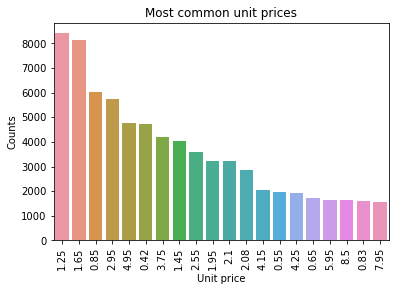

In [11]:
price_counts = data.UnitPrice.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(6,4))
sns.barplot(x = price_counts.index, y = price_counts.values, order = price_counts.index)
plt.ylabel("Counts")
plt.xlabel("Unit price")
plt.title("Most common unit prices");
plt.xticks(rotation=90);
#plt.savefig('common_unit_prices.png', dpi=300, bbox_inches="tight")
plt.show()

In [12]:
ranges = [0,1,5,10,25,50,75,100,500,1000,5000]
data.UnitPrice.groupby(pd.cut(data.UnitPrice, ranges)).count()

UnitPrice
(0, 1]          21708
(1, 5]          60405
(5, 10]         10485
(10, 25]         4791
(25, 50]         1438
(50, 75]           20
(75, 100]          11
(100, 500]        140
(500, 1000]        44
(1000, 5000]       44
Name: UnitPrice, dtype: int64

In [13]:
print('90 % of the invoices have a unit price less than',data.UnitPrice.quantile(0.90),'pounds')
print('99 % of the invoices have a unit price less than',data.UnitPrice.quantile(0.99),'pounds')

90 % of the invoices have a unit price less than 8.29 pounds
99 % of the invoices have a unit price less than 40.0 pounds


As expected items with a low price range are those ordered most. 90 % of the invoices have a unit price less than 8.29 pounds and
99 % of the invoices have a unit price less than 40.0 pounds. 

Is there any temporal patterns for when most expensive items are sold?

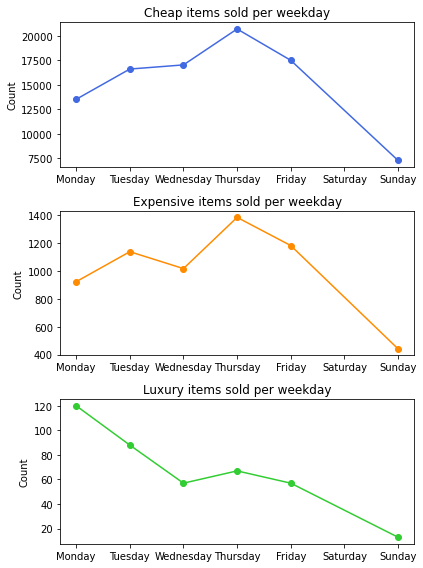

In [14]:
cheap_items = data.loc[data['UnitPrice'] < 10]
expensive_items = data.loc[(data['UnitPrice'] >= 10) & (data['UnitPrice'] <= 40)]
luxury_items = data.loc[data['UnitPrice'] > 40]
                                    
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(6,8))

axs[0].plot(cheap_items.groupby('Weekday').size(), marker='o', color='royalblue')
axs[1].plot(expensive_items.groupby('Weekday').size(), marker='o', color='darkorange')
axs[2].plot(luxury_items.groupby('Weekday').size(), marker='o', color='limegreen')

axs[0].set_title('Cheap items sold per weekday')
axs[1].set_title('Expensive items sold per weekday')
axs[2].set_title('Luxury items sold per weekday')

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Count', xticks = np.arange(0,7), xticklabels= weekdays)
#plt.savefig('item_prices_weekday.png', dpi=300, bbox_inches="tight")
plt.show()

- Cheap and moderately expensive items follow (almost) the same pattern of sales, concentrated between Tuesday and Friday, peaking on Thursday
- Luxury items which are mostly purchased at the beginning of the week, Monday and Tuesday. E-mails suggestions for luxury items should be sent on Monday and Tuesday. 

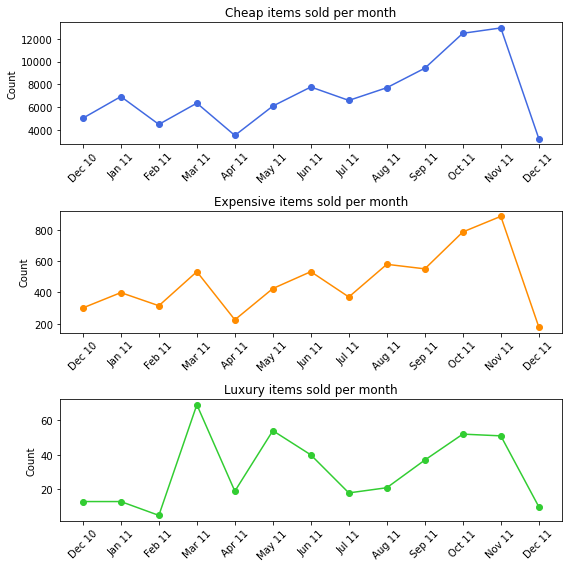

In [15]:
yearmonth = ['Dec 10', 'Jan 11', 'Feb 11', 'Mar 11', 'Apr 11', 'May 11',
             'Jun 11', 'Jul 11', 'Aug 11', 'Sep 11', 'Oct 11', 'Nov 11', 'Dec 11']

fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8,8))

axs[0].set_title('Cheap items sold per month')
axs[1].set_title('Expensive items sold per month')
axs[2].set_title('Luxury items sold per month')

axs[0].plot(cheap_items.groupby(['Year','Month']).size().values, marker='o', color='royalblue')
axs[1].plot(expensive_items.groupby(['Year','Month']).size().values, marker='o', color='darkorange')
axs[2].plot(luxury_items.groupby(['Year','Month']).size().values, marker='o', color='limegreen')

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Count', xticks = np.arange(0, len(yearmonth)))
    
axs[0].set_xticklabels(yearmonth, rotation=45)
axs[1].set_xticklabels(yearmonth, rotation=45)
axs[2].set_xticklabels(yearmonth, rotation=45)

#plt.savefig('item_price_month.png', dpi=300, bbox_inches="tight")
plt.show()

### Focus on data with quantity >0  

From the exploratory analysis we know that  88884 entries have a missing value for the variable Quantity (almost 90% of the data), and 890 entries with negative quantities are cancelled orders or returns (over 911 total entries with negative quantity). There are no cancelled orders with quantity > 0. We discard all the entries with negative quantity and compute the revenue for all the entries left.

In [16]:
pos_quant = data.loc[data.Quantity > 0]
print('We can compute the revenue only for',pos_quant.shape[0],'entries, that is',pos_quant.shape[0]/ data.shape[0] * 100, '% of the data') 

We can compute the revenue only for 9387 entries, that is 9.46441894698635 % of the data


In [17]:
quantity_data = data.loc[data.Quantity > 0].copy()
quantity_data.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,EstoreID,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
1,2011-12-09 09:07:00,581480,23355,HOT WATER BOTTLE KEEP CALM,12.0,4.95,14441.0,United Kingdom,20,2011,4,12,49,4,9,343,2011-12-09
2,2011-12-07 12:55:00,581132,NaN,NaN,4.0,4.95,17590.0,United Kingdom,1,2011,4,12,49,2,7,341,2011-12-07
3,2011-06-23 14:11:00,557892,NaN,NaN,2.0,6.35,14534.0,United Kingdom,17,2011,2,6,25,3,23,174,2011-06-23
4,2011-01-25 14:01:00,542115,84992,NaN,1.0,2.08,NaN,United Kingdom,6,2011,1,1,4,1,25,25,2011-01-25
5,2011-12-01 11:51:00,580024,35964,NaN,36.0,0.39,15172.0,United Kingdom,32,2011,4,12,48,3,1,335,2011-12-01


In [18]:
quantity_data.Quantity.min()
print('Now the minimum quantity is', quantity_data.Quantity.min())
print('and in total there are', quantity_data.Quantity.nunique(),'possible quantity values') # 1, 89

Now the minimum quantity is 1.0
and in total there are 89 possible quantity values


<AxesSubplot:>

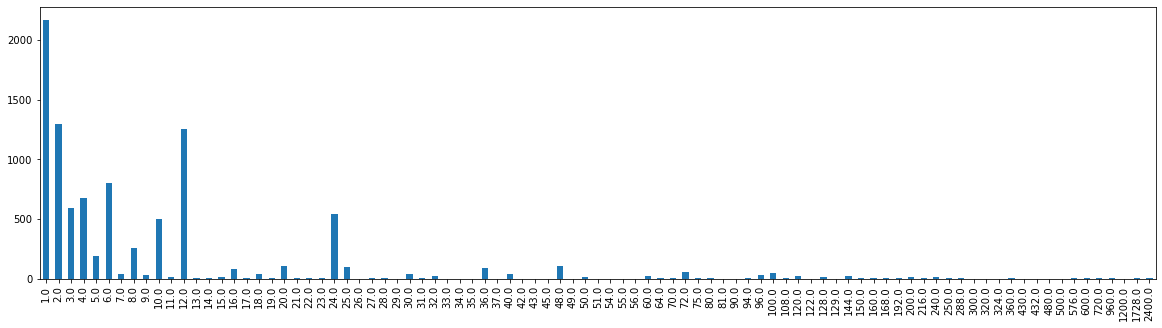

In [19]:
quantity_data['Quantity'].value_counts().sort_index().plot(kind='bar',figsize=(20, 5))
#plt.savefig('quantity_hist.png', dpi=300)
#plt.show()

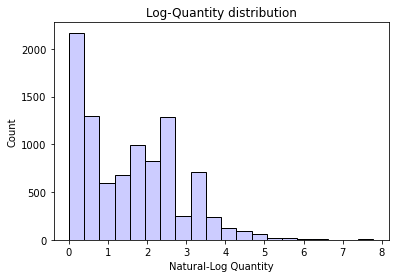

In [20]:
fig, ax = plt.subplots()
sns.histplot(np.log(quantity_data.Quantity), ax=ax, bins=20, kde=False, color="blue", alpha=0.2);
ax.set_title('Log-Quantity distribution')
ax.set_xlabel('Natural-Log Quantity');

The orders with large amount of a product might be retailers. Let's compute the total price for each invoice. 

In [21]:
quantity_data['TotPrice'] = quantity_data.Quantity * quantity_data.UnitPrice
quantity_data.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,EstoreID,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,TotPrice
1,2011-12-09 09:07:00,581480,23355,HOT WATER BOTTLE KEEP CALM,12.0,4.95,14441.0,United Kingdom,20,2011,4,12,49,4,9,343,2011-12-09,59.40
2,2011-12-07 12:55:00,581132,NaN,NaN,4.0,4.95,17590.0,United Kingdom,1,2011,4,12,49,2,7,341,2011-12-07,19.80
3,2011-06-23 14:11:00,557892,NaN,NaN,2.0,6.35,14534.0,United Kingdom,17,2011,2,6,25,3,23,174,2011-06-23,12.70
4,2011-01-25 14:01:00,542115,84992,NaN,1.0,2.08,NaN,United Kingdom,6,2011,1,1,4,1,25,25,2011-01-25,2.08
5,2011-12-01 11:51:00,580024,35964,NaN,36.0,0.39,15172.0,United Kingdom,32,2011,4,12,48,3,1,335,2011-12-01,14.04


In [22]:
quantity_data.loc[:,['Quantity','TotPrice']].describe()

,Quantity,TotPrice
count,9387.000000,9387.000000
mean,13.532012,28.381963
std,61.405447,127.101678
min,1.000000,0.000000
25%,2.000000,4.950000
50%,4.000000,12.750000
75%,12.000000,19.920000
max,2400.000000,4992.000000


In [23]:
high_quantity = quantity_data.Quantity.quantile(0.99)
high_tot_price = quantity_data.TotPrice.quantile(0.99)
print('99 % of the Quantity values are less than',high_quantity)
print('99 % of the TotPrice values are less than',high_tot_price)
print('High quantity entries:',quantity_data.loc[quantity_data['TotPrice'] >= high_quantity].shape[0])
print('High tot price entries:',quantity_data.loc[quantity_data['TotPrice'] >= high_tot_price].shape[0])
print('High quantity, high tot price entries:',quantity_data.loc[(quantity_data['Quantity'] >= high_quantity) & (quantity_data['TotPrice'] >= high_tot_price)].shape[0])
print('High tot price, not high quantity entries:',quantity_data.loc[(quantity_data['Quantity'] < high_quantity) & (quantity_data['TotPrice'] >= high_tot_price)].shape[0])
print('High quantity, not high tot price entries:',quantity_data.loc[(quantity_data['Quantity'] >= high_quantity) & (quantity_data['TotPrice'] < high_tot_price)].shape[0])

99 % of the Quantity values are less than 128.0
99 % of the TotPrice values are less than 283.3811999999985
High quantity entries: 277
High tot price entries: 94
High quantity, high tot price entries: 53
High tot price, not high quantity entries: 41
High quantity, not high tot price entries: 50


Quantity and Revenue show extreme outliers. Scatterplot with all quantity data and also removing outliers: 

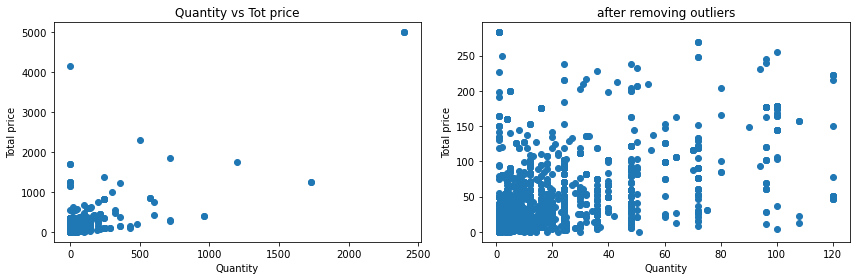

In [24]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12, 4));
axs[0].scatter(x='Quantity', y='TotPrice',data= quantity_data);
axs[0].set_xlabel("Quantity") 
axs[0].set_ylabel("Total price") 
axs[0].set_title("Quantity vs Tot price");

quantity_data_cleaned = quantity_data.loc[(quantity_data['Quantity'] < high_quantity) & (quantity_data['TotPrice'] < high_tot_price)].copy()
axs[1].scatter(x='Quantity', y='TotPrice',data= quantity_data_cleaned);
axs[1].set_xlabel("Quantity") 
axs[1].set_ylabel("Total price") 
axs[1].set_title("after removing outliers");

plt.show()

### Quantity and revenue
We will look at how the total amount of products sold and the generated revenue are distributed in time. 
We can also look at which customers place the highest revenue orders and their country.  
This analysis is based on about 10 % of the data.

First we compute the total quantity and revenue for each order (items sharing same InvoiceNo). 

In [25]:
group_var = ['InvoiceDate', 'Date', 'Year', 'Quarter', 'Month', 'Week', 'Weekday', 'Dayofyear', 'Day', 'Country', 'EstoreID', 'CustomerID', 'InvoiceNo']

revenue_data = pd.DataFrame(quantity_data.groupby(group_var).Quantity.sum(),columns=['Quantity'])
revenue_data['Revenue'] = quantity_data.groupby(group_var).TotPrice.sum()
revenue_data = revenue_data.reset_index()
revenue_data.head()

,InvoiceDate,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,Country,EstoreID,CustomerID,InvoiceNo,Quantity,Revenue
0,2010-12-01 09:02:00,2010-12-01,2010,4,12,48,2,335,1,United Kingdom,22,17850.0,536373,6.0,20.34
1,2010-12-01 10:29:00,2010-12-01,2010,4,12,48,2,335,1,United Kingdom,15,13705.0,536392,1.0,165.00
2,2010-12-01 10:53:00,2010-12-01,2010,4,12,48,2,335,1,United Kingdom,18,13448.0,536400,12.0,17.40
3,2010-12-01 11:21:00,2010-12-01,2010,4,12,48,2,335,1,United Kingdom,16,15862.0,536401,1.0,1.65
4,2010-12-01 11:27:00,2010-12-01,2010,4,12,48,2,335,1,Netherlands,1,12791.0,536403,96.0,177.60


<Figure size 432x288 with 0 Axes>

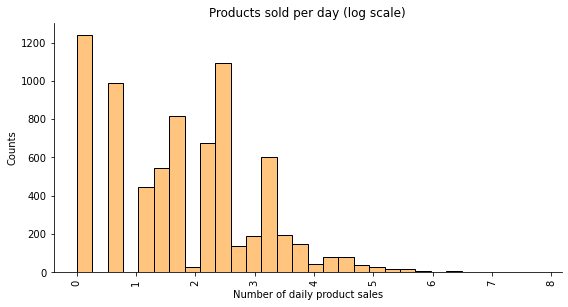

In [26]:
plt.figure(figsize=(6,4))
sns.displot(x = np.log(revenue_data.Quantity.values), color="darkorange", alpha=0.5, bins=30,  height=4, aspect=2);

plt.ylabel("Counts")
plt.xlabel("Number of daily product sales")
plt.title("Products sold per day (log scale)");
plt.xticks(rotation=90);
#plt.savefig('products_day_freq.png', dpi=300)
plt.show()


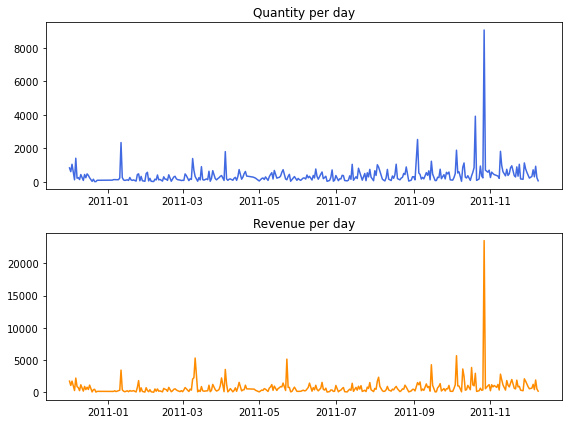

In [27]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(8, 6));

axs[0].plot(revenue_data.groupby("Date").Quantity.sum(), marker='', color='royalblue')
axs[1].plot(revenue_data.groupby("Date").Revenue.sum(), marker='', color='darkorange')
axs[0].set_title('Quantity per day')
axs[1].set_title('Revenue per day')
#plt.savefig('quantity_revenue_day.png', dpi=300, bbox_inches="tight")
plt.show()

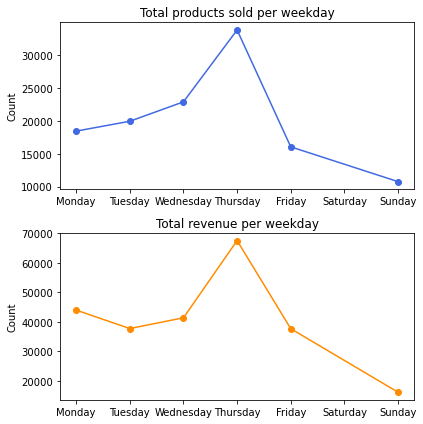

In [28]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(6,6))

axs[0].plot(revenue_data.groupby('Weekday').Quantity.sum(), marker='o', color='royalblue')
axs[1].plot(revenue_data.groupby('Weekday').Revenue.sum(), marker='o', color='darkorange')

axs[0].set_title('Total products sold per weekday')
axs[1].set_title('Total revenue per weekday')

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Count', xticks = np.arange(0,7), xticklabels= weekdays)

#plt.savefig('quantity_revenue_weekday.png', dpi=300, bbox_inches="tight")
plt.show()

Insights:

- Thursday is the day on which most products are sold and the revenue is highest, followed by Wednesday.
- Sunday has the lowest amount of products sold and revenue as well 
- On Saturday there are no transactions at all (the eStore is closed). 

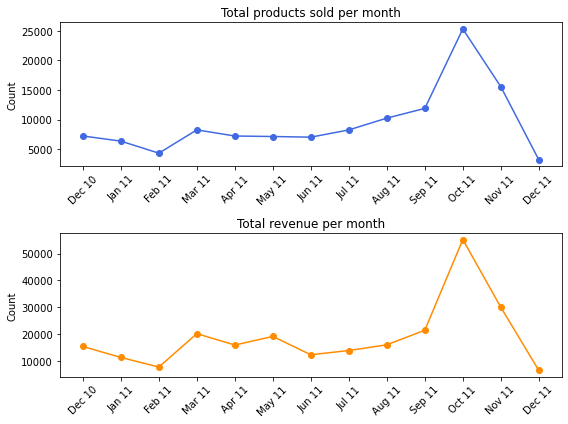

In [29]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(8,6))

axs[0].plot(revenue_data.groupby(['Year','Month'])['Quantity'].sum().values, marker='o', color='royalblue')
axs[1].plot(revenue_data.groupby(['Year','Month'])['Revenue'].sum().values, marker='o', color='darkorange')

axs[0].set_title('Total products sold per month')
axs[1].set_title('Total revenue per month')

for ax in axs.flat:
    ax.set(xlabel='', ylabel='Count', xticks = np.arange(0, len(yearmonth)))

axs[0].set_xticklabels(yearmonth, rotation=45)
axs[1].set_xticklabels(yearmonth, rotation=45)

#plt.savefig('quantity_revenue_month.png', dpi=300, bbox_inches="tight")
plt.show()

Insights:
- October and november have the highest quantity of products sold and highest revenue (pre-Christmas season) 
- The revenue is especially high on March, while the quantity is not. Notice that the highest revenue order (outlier) is in March.
- February is the month with lowest quantity sold as well as lowest revenue

Obviously, there is a strong correlation between Quantity and Revenue, but sometimes the revenue or the quantity can be much higher or lower than the other depending on the cost of the item. 

#### Revenue by e-store

In [30]:
estore_revenue = revenue_data.groupby(['EstoreID'])['Revenue'].sum()
# print(estore_revenue)

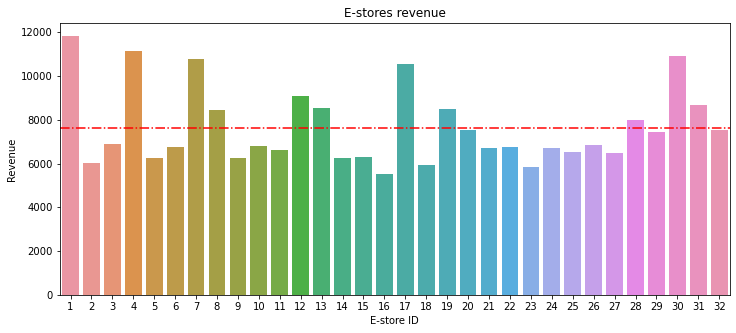

In [31]:
plt.figure(figsize=(12,5))
sns.barplot(x = estore_revenue.index, y = estore_revenue.values)
plt.ylabel("Revenue")
plt.xlabel("E-store ID")
plt.title("E-stores revenue");
plt.axhline(y=estore_revenue.mean(), color='r', linestyle='-.')
#plt.savefig('revenue_estore.png', dpi=300, bbox_inches="tight")
plt.show()

#### Revenue by country

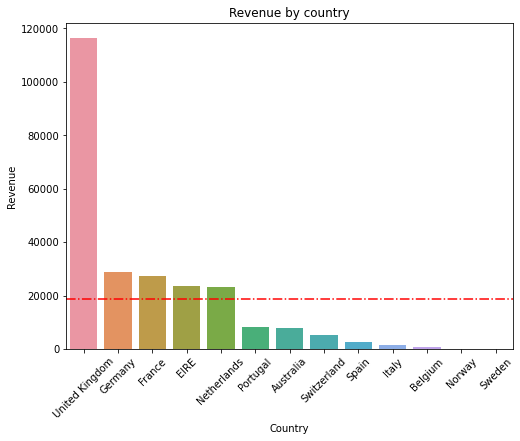

In [32]:
country_revenue = revenue_data.groupby(['Country'])['Revenue'].sum()
idx = data.Country.unique()
country_revenue = country_revenue.reindex(idx, fill_value=0)
country_revenue = country_revenue.sort_values(ascending = False)

plt.figure(figsize=(8,6))
sns.barplot(x = country_revenue.index, y = country_revenue.values)
plt.ylabel("Revenue")
plt.xlabel("Country")
plt.title("Revenue by country");
plt.xticks(rotation=45);
plt.axhline(y = country_revenue.mean(), color='r', linestyle='-.')

#plt.savefig('revenue_country.png', dpi=300, bbox_inches="tight")
plt.show()

This result must be taken with a grain of salt since is based on limited data. For instance, no entry of orders from Sweden has the quantity registered, therefore no revenue could be calculated. If the quantities would be registered we could have a clearer pictures of which countries generates most revenue and this information could direct marketing campaigns.

#### Highest spending customers

In [33]:
# The ten highest revenue orders
highest_revenue = revenue_data.Revenue.sort_values(ascending=False)[1:10]
revenue_data.nlargest(10, columns=['Revenue'])

,InvoiceDate,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,Country,EstoreID,CustomerID,InvoiceNo,Quantity,Revenue
5827,2011-10-27 12:11:00,2011-10-27,2011,4,10,43,3,300,27,Netherlands,1,14646.0,573003,2400.0,4992.00
5828,2011-10-27 12:11:00,2011-10-27,2011,4,10,43,3,300,27,Netherlands,7,14646.0,573003,2400.0,4992.00
5829,2011-10-27 12:11:00,2011-10-27,2011,4,10,43,3,300,27,Netherlands,30,14646.0,573003,2400.0,4992.00
5845,2011-10-27 14:20:00,2011-10-27,2011,4,10,43,3,300,27,France,17,12536.0,573080,1.0,4161.06
4733,2011-09-15 15:34:00,2011-09-15,2011,3,9,37,3,258,15,United Kingdom,4,18102.0,566934,500.0,2290.00
5392,2011-10-11 11:15:00,2011-10-11,2011,4,10,41,1,284,11,United Kingdom,29,16029.0,570557,720.0,1836.00
6212,2011-11-09 13:56:00,2011-11-09,2011,4,11,45,2,313,9,United Kingdom,13,12931.0,575335,1200.0,1740.00
1415,2011-03-11 10:19:00,2011-03-11,2011,1,3,10,4,70,11,EIRE,8,14911.0,546328,1.0,1687.17
1416,2011-03-11 10:22:00,2011-03-11,2011,1,3,10,4,70,11,EIRE,4,14911.0,546329,1.0,1687.17
1417,2011-03-11 10:22:00,2011-03-11,2011,1,3,10,4,70,11,EIRE,31,14911.0,546329,1.0,1687.17


Notice that the same CustomerID reappear in some of the highest revenue orders that have been placed.

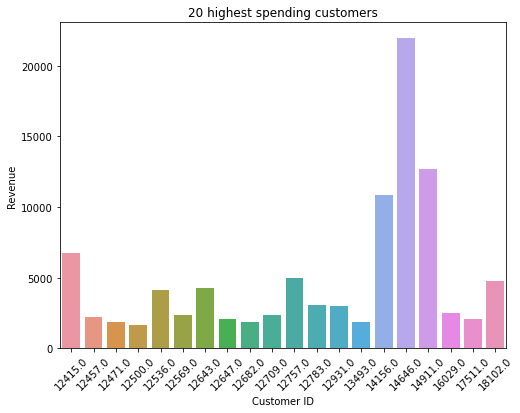

In [34]:
customer_revenue = revenue_data.groupby(['CustomerID'])['Revenue'].sum()
customer_revenue = customer_revenue.sort_values(ascending = False).iloc[0:20] 

plt.figure(figsize=(8,6))
sns.barplot(x = customer_revenue.index, y = customer_revenue.values)
plt.ylabel("Revenue")
plt.xlabel("Customer ID")
plt.title("20 highest spending customers");
plt.xticks(rotation=45);

#plt.savefig('high_revenue_customers.png', dpi=300, bbox_inches="tight")
plt.show()

## II. Customer Relationship Management 

Customer Relationship Management (CRM) is a strategy that companies use to manage interactions with customers and potential customers. We can do some basic CRM analytics for the revenue data, using the **RFM model**, which is based on three quantitative factors:
- Recency: How recent is the last purchase of the customer.
- Frequency: How often the customer makes a purchase.
- Monetary: How much money does the customer spends.

What can be used for:
- marketing campaigns
- improving customer's loyalty

We have the customerID for most orders, so we can focus our analysis on the first two components Recency and Frequency. 
Even if we have the Customer ID for all the Revenue data it is still less than 10 % of the entries.

We can have many invoices for a specific order, each related to an item, but we are interested in the orders, not the invoices.
Let's aggregate the invoices in orders.

In [35]:
data['Cancelled']=np.where(data.InvoiceNo.apply(lambda l: l[0]=='C'), True, False)
data_clean = data.loc[(data.Cancelled==False)&((data.Quantity < 0) == False)].copy()
orders = data_clean[['InvoiceDate', 'InvoiceNo', 'CustomerID','EstoreID']].copy()
orders.dropna(subset=['CustomerID'], inplace=True)
orders.head()

,InvoiceDate,InvoiceNo,CustomerID,EstoreID
1,2011-12-09 09:07:00,581480,14441.0,20
2,2011-12-07 12:55:00,581132,17590.0,1
3,2011-06-23 14:11:00,557892,14534.0,17
5,2011-12-01 11:51:00,580024,15172.0,32
6,2011-01-27 10:30:00,542277,14440.0,9


In [36]:
orders.drop_duplicates(inplace = True)
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37831 entries, 1 to 129891
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  37831 non-null  datetime64[ns]
 1   InvoiceNo    37831 non-null  object        
 2   CustomerID   37831 non-null  float64       
 3   EstoreID     37831 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.4+ MB


In [37]:
orders.InvoiceNo.nunique()

6573

In [38]:
print(orders[orders.duplicated(subset=['InvoiceNo'],keep=False)])

               InvoiceDate InvoiceNo  CustomerID  EstoreID
2      2011-12-07 12:55:00    581132     17590.0         1
3      2011-06-23 14:11:00    557892     14534.0        17
6      2011-01-27 10:30:00    542277     14440.0         9
10     2011-07-14 11:20:00    559979     14862.0        14
12     2011-07-17 14:51:00    560271     16474.0        24
...                    ...       ...         ...       ...
129442 2011-12-05 16:26:00    580704     17404.0         6
129478 2011-03-10 09:52:00    546161     17404.0        11
129775 2011-10-14 11:44:00    571191     17404.0        12
129865 2011-12-05 16:26:00    580704     17404.0        10
129891 2011-11-22 17:02:00    578089     12483.0        19

[34297 rows x 4 columns]


These most likely are errors / delays in the InvoiceDate. Let's keep the first invoice.

In [39]:
orders = orders.drop_duplicates(subset=['InvoiceNo'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6573 entries, 1 to 122836
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  6573 non-null   datetime64[ns]
 1   InvoiceNo    6573 non-null   object        
 2   CustomerID   6573 non-null   float64       
 3   EstoreID     6573 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 256.8+ KB


In [40]:
today = revenue_data['Date'].max() + timedelta(days=2) 
today

Timestamp('2011-12-11 00:00:00')

In [41]:
period = 365 # days

orders['DaysSinceOrder'] = orders['InvoiceDate'].apply(lambda x: (today - x).days)

aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
    'InvoiceDate': lambda x: len([d for d in x if d >= today - timedelta(days=period)]), # the total number of orders in the last period (Frequency)
}
RFM = orders.groupby('CustomerID').agg(aggr).reset_index()
RFM.rename(columns={'DaysSinceOrder': 'Recency', 'InvoiceDate': 'Frequency'}, inplace=True)
RFM.head()
RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2575 entries, 0 to 2574
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  2575 non-null   float64
 1   Recency     2575 non-null   int64  
 2   Frequency   2575 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 60.5 KB


#### RFM scores

Each customer will get a score between 1 and 5 for each parameter. This can be done on the base of set ranges, or using quantiles each containing 20 % of the population. Using quintiles is more flexible since the ranges adapt to the data and would work across different industries or if there's any change in expected customer behavior.

In [42]:
RFM['Rscore'] = pd.qcut(RFM['Recency'], q=5, labels=[5,4,3,2,1]) # this gives quantiles (5)
RFM['Fscore'] = pd.qcut(RFM['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
RFM['RFscore'] = (RFM['Rscore'].astype(str)+ RFM['Fscore'].astype(str)) 
RFM.head()

,CustomerID,Recency,Frequency,Rscore,Fscore,RFscore
0,12349.0,19,1,5,1,51
1,12350.0,311,1,1,1,11
2,12352.0,37,8,4,5,45
3,12354.0,233,1,1,1,11
4,12356.0,23,3,4,4,44


In [43]:
# Segmentation
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at risk',
           r'[1-2]5': 'cant loose',
           r'3[1-2]': 'about to sleep',
           r'33': 'need attention',
           r'[3-4][4-5]': 'loyal customers',
           r'41': 'promising',
           r'51': 'new customers',
           r'[4-5][2-3]': 'potential loyalists',
           r'5[4-5]': 'champions'}

RFM['Segment'] = RFM['RFscore'].replace(seg_map, regex=True)
RFM.head()

,CustomerID,Recency,Frequency,Rscore,Fscore,RFscore,Segment
0,12349.0,19,1,5,1,51,new customers
1,12350.0,311,1,1,1,11,hibernating
2,12352.0,37,8,4,5,45,loyal customers
3,12354.0,233,1,1,1,11,hibernating
4,12356.0,23,3,4,4,44,loyal customers


In [44]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2575 entries, 0 to 2574
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CustomerID  2575 non-null   float64 
 1   Recency     2575 non-null   int64   
 2   Frequency   2575 non-null   int64   
 3   Rscore      2575 non-null   category
 4   Fscore      2575 non-null   category
 5   RFscore     2575 non-null   object  
 6   Segment     2575 non-null   object  
dtypes: category(2), float64(1), int64(2), object(2)
memory usage: 106.2+ KB


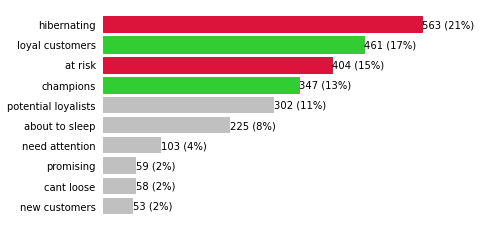

In [45]:
# count the number of customers in each segment
segments_counts = RFM['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('limegreen')
        if segments_counts.index[i] in ['hibernating', 'at risk']:
            bar.set_color('crimson')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
#plt.savefig('customers_segments.png', dpi=300, bbox_inches="tight")
plt.show()

- 21 % of customers are hibernating and 15 % are at risk.
- 30 % of customers are either champions or loyal customers.

## III. Description keywords

Let's see which keywords are most common in the descriptions of the ordered products. First, we create a dictionary of the words from the descriptions.

The following function keywords_parse does the following returns four variables:
- category_keys: the list of the keywords extracted from the items descriptions
- keyword_select: a dictionary of the words associated
- keywords_roots: a dictionary where the keys are the keyword roots and the values are the lists of words associated with those roots
- count_keywords: a dictionary listing the number of times each keyword root appears

In [46]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_parse(dataframe, feature = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english") # Stemmers remove morphological affixes from words, leaving only the word stem
    keywords_roots  = dict()  # collect the word roots
    keywords_associate = dict()  # associate keywords
    category_keys   = []
    keywords_count  = dict()
    icount = 0
    
    # extract the words in the descriptions
    for s in dataframe[feature]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines) # divide lines into lists of substrings
        words = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        # for each word:
        # - extract the root of the word
        # - aggregate the set of words associated with this particular root
        # - count the number of times the root appears
        for t in words:
            t = t.lower() ; root = stemmer.stem(t)
            if root in keywords_roots:                
                keywords_roots[root].add(t)
                keywords_count[root] += 1                
            else:
                keywords_roots[root] = {t}
                keywords_count[root] = 1
                
    # when several words are listed for the same root, the keyword is the shortest word
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    c = k ; min_length = len(k)            
            category_keys.append(c)
            keywords_associate[s] = c
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_associate[s] = list(keywords_roots[s])[0]
                   
    print("The number of keywords in '{}'is {}".format(feature,len(category_keys)))
    return category_keys, keywords_roots, keywords_associate, keywords_count

In [47]:
products = pd.DataFrame(data['Description'].unique()).rename(columns = {0:'Description'})

In [48]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rachel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [49]:
keywords, keywords_roots, keywords_associate, keywords_count = keywords_parse(products)

The number of keywords in 'Description'is 876


#### Most common keywords

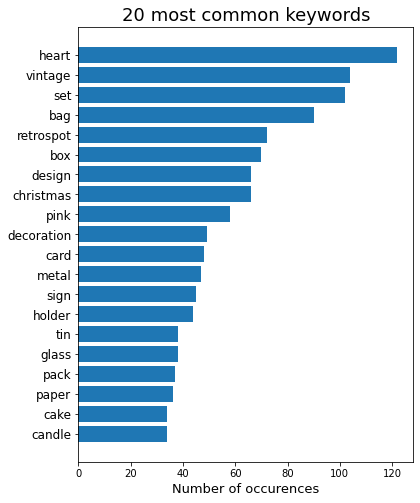

In [50]:
# convert to a list 
keywords_list = []
for k,v in keywords_count.items():
    keywords_list.append([keywords_associate[k],v])
keywords_list = sorted(keywords_list, key = lambda x:x[1], reverse = True) # sort from most common to least common keywords
# print('There are',len(keywords_list),'keywords') # 876

# plot 20 most common keywords
fig = plt.figure(figsize=(6,8))
x = [k for k,i in enumerate(keywords_list[:20])]
y = [i[1] for i in keywords_list[:20]]
plt.barh(x, y)
plt.gca().invert_yaxis()
x_label = [i[0] for i in keywords_list[:20]]
plt.yticks(x, x_label, fontsize = 12)
plt.xlabel('Number of occurences', fontsize = 13)
plt.title('20 most common keywords', fontsize ='18')
#plt.savefig('most_common_keywords.png', dpi=300, bbox_inches="tight")
plt.show()

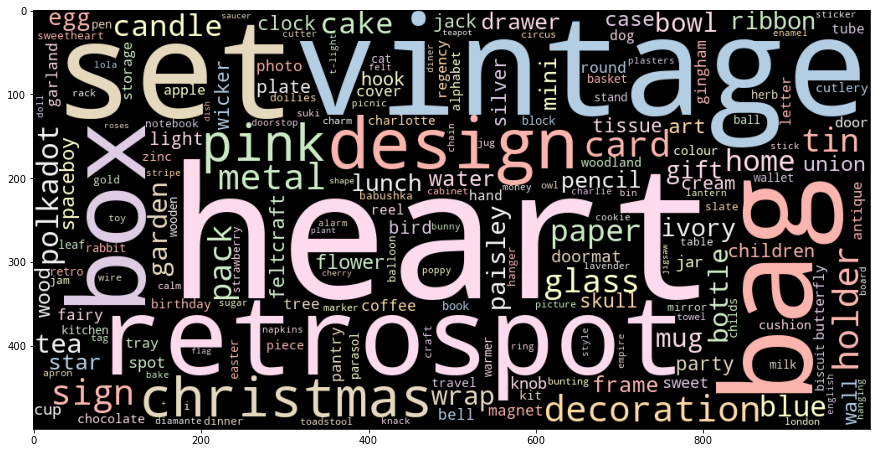

In [51]:
# convert list to dictionary
keywords_dict = dict(keywords_list) 

wordcloud = WordCloud(width = 1000, height = 500, colormap= 'Pastel1').generate_from_frequencies(keywords_dict)
 
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

# wordcloud.to_file("wordcloud1.png")